In [ ]:
!pip install tensorflow==2.9.0
!pip install ampligraph
!pip install --upgrade xgboost
!pip install scikit-learn==1.0.2
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!cd incf.countryutils && pip install .
!pip install adjustText

In [ ]:
import numpy as np
import pandas as pd
import ampligraph
import tensorflow as tf
from ampligraph.evaluation import train_test_split_no_unseen, mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer
from ampligraph.discovery import find_clusters
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Load the dataset
df = pd.read_csv("cards.csv")
df

,Card name,Minion type,Tavern level,Price,Percent Benefit,combines_with_race
0,'Loc_Prince,MURLOC,4_level,3_coin,15_percent_benefit,NaN
1,Accord-o-Tron,MECHANICAL,3_level,3_coin,12_percent_benefit,NaN
2,Adaptive_Ancestor,MURLOC,3_level,3_coin,18_percent_benefit,NaN
3,Admiral_Eliza_Goreblade,PIRATE,6_level,3_coin,0_percent_benefit,NaN
4,Ancestral_Automaton,MECHANICAL,2_level,3_coin,17_percent_benefit,ELEMENTAL
...,...,...,...,...,...,...
309,Time_Management,NONE_RACE,3_level,3_coin,1_percent_benefit,NaN
310,Toxic_Tumbleweed,NONE_RACE,4_level,3_coin,2_percent_benefit,NaN
311,Tricky_Trousers,NONE_RACE,3_level,3_coin,19_percent_benefit,NaN
312,Unmasked_Identity,NONE_RACE,5_level,3_coin,7_percent_benefit,NaN


In [ ]:
df['Card name'] = df['Card name'].str.replace("'", "").str.replace(",", "")
df['Minion type'] = df['Minion type'].str.upper()
df['Tavern level'] = df['Tavern level'].str.split('_').str[0].astype(int)
df['Price'] = df['Price'].str.split('_').str[0].astype(int)
df['Percent Benefit'] = df['Percent Benefit'].str.split('_').str[0].astype(int)
df['combines_with_race'] = df['combines_with_race'].fillna('NONE')

df['card_id'] = "Card" + df['Card name'].str.replace(" ", "")
df['minion_type_id'] = "Type" + df['Minion type'].str.replace(" ", "")
df['combines_with_id'] = "CombinesWith" + df['combines_with_race'].str.replace(" ", "")

df

,Card name,Minion type,Tavern level,Price,Percent Benefit,combines_with_race,card_id,minion_type_id,combines_with_id
0,Loc_Prince,MURLOC,4,3,15,NONE,CardLoc_Prince,TypeMURLOC,CombinesWithNONE
1,Accord-o-Tron,MECHANICAL,3,3,12,NONE,CardAccord-o-Tron,TypeMECHANICAL,CombinesWithNONE
2,Adaptive_Ancestor,MURLOC,3,3,18,NONE,CardAdaptive_Ancestor,TypeMURLOC,CombinesWithNONE
3,Admiral_Eliza_Goreblade,PIRATE,6,3,0,NONE,CardAdmiral_Eliza_Goreblade,TypePIRATE,CombinesWithNONE
4,Ancestral_Automaton,MECHANICAL,2,3,17,ELEMENTAL,CardAncestral_Automaton,TypeMECHANICAL,CombinesWithELEMENTAL
...,...,...,...,...,...,...,...,...,...
309,Time_Management,NONE_RACE,3,3,1,NONE,CardTime_Management,TypeNONE_RACE,CombinesWithNONE
310,Toxic_Tumbleweed,NONE_RACE,4,3,2,NONE,CardToxic_Tumbleweed,TypeNONE_RACE,CombinesWithNONE
311,Tricky_Trousers,NONE_RACE,3,3,19,NONE,CardTricky_Trousers,TypeNONE_RACE,CombinesWithNONE
312,Unmasked_Identity,NONE_RACE,5,3,7,NONE,CardUnmasked_Identity,TypeNONE_RACE,CombinesWithNONE


In [ ]:
# Create triples
triples = []
for _, row in df.iterrows():
    card_to_type = (row['card_id'], 'isOfType', row['minion_type_id'])
    card_to_benefit = (row['card_id'], 'hasBenefit', str(row['Percent Benefit']))
    card_to_price = (row['card_id'], 'hasPrice', str(row['Price']))
    card_to_combines = (row['card_id'], 'combinesWith', row['combines_with_id'])
    triples.extend([card_to_type, card_to_benefit, card_to_price, card_to_combines])


triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])

In [ ]:
X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=100)

In [ ]:
model = ScoringBasedEmbeddingModel(k=100, eta=20, scoring_type='ComplEx', seed=0)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})
model.compile(optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer)

In [ ]:
model.fit(X_train, batch_size=int(X_train.shape[0] / 50), epochs=300, verbose=True)

In [ ]:
ranks = model.evaluate(X_valid, use_filter={'train': X_train, 'test': X_valid}, corrupt_side='s,o', verbose=True)

In [ ]:
mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.39
MR: 49.44
Hits@10: 0.59
Hits@3: 0.40
Hits@1: 0.30


In [ ]:
# Clustering and embedding visualization

cards = df['card_id'].unique()
card_embeddings = dict(zip(cards, model.get_embeddings(cards)))

embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in card_embeddings.values()]))

In [ ]:
clustering_algorithm = KMeans(n_clusters=6, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(cards, model, clustering_algorithm, mode='e')

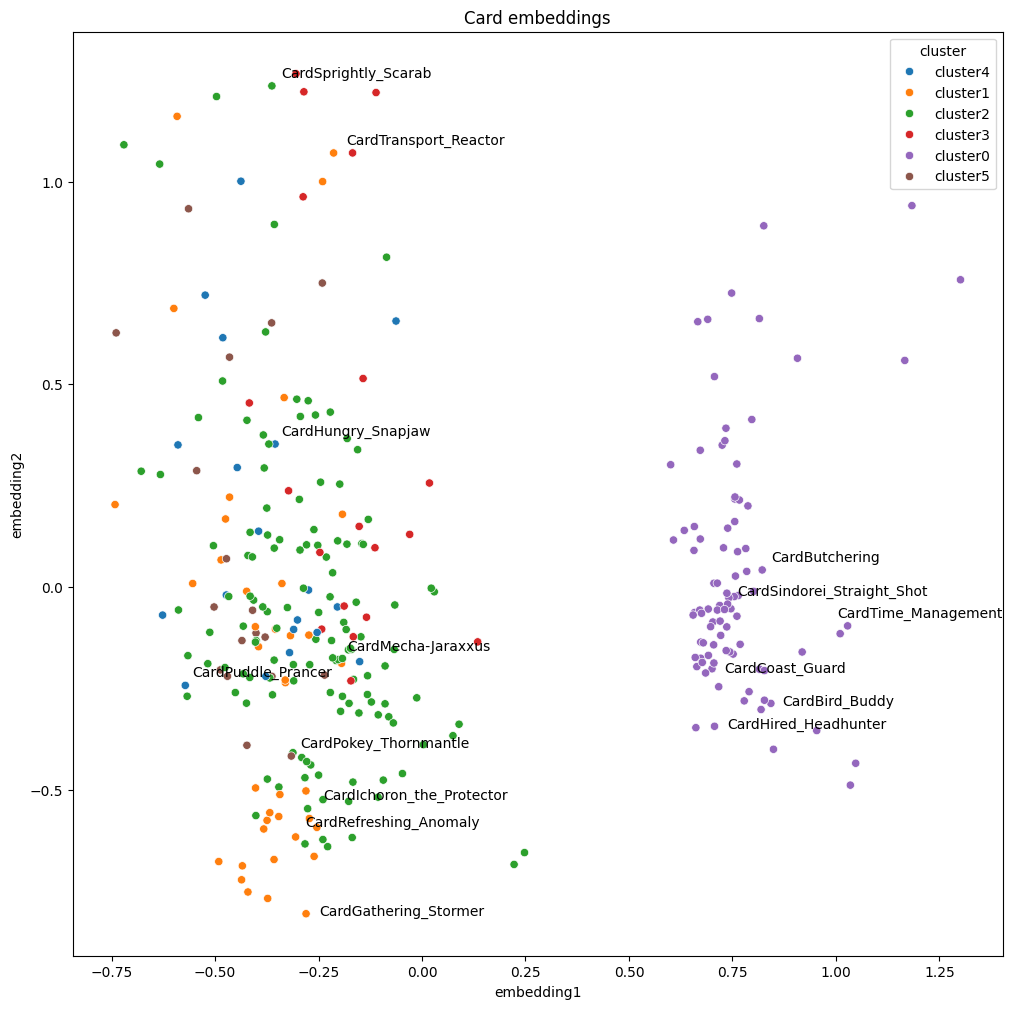

In [ ]:
plot_df = pd.DataFrame({
    "cards": cards,
    "embedding1": embeddings_2d[:, 0],
    "embedding2": embeddings_2d[:, 1],
    "cluster": "cluster" + pd.Series(clusters).astype(str)
})

def plot_clusters():
    plt.figure(figsize=(12, 12))
    plt.title("Card embeddings")
    ax = sns.scatterplot(data=plot_df, x="embedding1", y="embedding2", hue="cluster")
    texts = []
    for i, point in plot_df.iterrows():
        if np.random.random() < 0.05:
          texts.append(plt.text(point['embedding1']+0.02, point['embedding2']+0.01, str(point["cards"])))
    adjust_text(texts)

plot_clusters()

In [ ]:
# Classification
def get_features_target(mask):
    def get_embeddings(card):
        return card_embeddings.get(card, np.full(200, np.nan))

    X = np.vstack(df[mask]['card_id'].apply(get_embeddings).values)
    y = df[mask]['Percent Benefit'].values
    return X, y

In [ ]:
X_train, y_train = get_features_target(df['Tavern level'] <= 4)
X_test, y_test = get_features_target(df['Tavern level'] > 4)

In [ ]:
# Train an XGBoost classifier
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")
clf_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [ ]:
accuracy = clf_model.score(X_test, y_test)
print(f"Model accuracy: {accuracy}")

Model accuracy: 0.6896551724137931


In [ ]:
# Link prediction

# function to predict the best card to buy
def predict_best_card(owned_cards, tavern_cards):
    owned_embeddings = np.array([card_embeddings[card] for card in owned_cards])
    tavern_embeddings = np.array([card_embeddings[card] for card in tavern_cards])

    similarities = np.dot(tavern_embeddings, owned_embeddings.T).mean(axis=1)

    best_card_index = np.argmax(similarities)

    return tavern_cards[best_card_index]

 # ПРИМЕР

In [ ]:
# Example

owned_cards = ["Accord-o-Tron", "Annoy-o-Tron"]
tavern_cards = ["Loc Prince", "Adaptive Ancestor", "Admiral Eliza Goreblade"]

best_card = predict_best_card(owned_cards, tavern_cards)
print(f"The best card to buy is: {best_card}")

The best card to buy is: Adaptive Ancestor
